In [ ]:
# Importar modulo propio
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/modulos')
import ML
# Importar librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import numpy.random as nrd
import math
import sklearn as skl

Mounted at /content/drive


In [ ]:
# Subir el archivo ZIP al entorno de Google Colab
from google.colab import files
#Subir el archivo ZIP con el nombre "archive"
uploaded = files.upload()
#Descomprimir el archivo ZIP
import zipfile
import os
#Nombre del archivo ZIP subido
zip_filename = 'archive.zip'
#Carpeta de destino para extraer los archivos
extract_folder = '/content/soccer_dataset'
#Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
# Mostrar la lista de archivos en la carpeta extraída
os.listdir(extract_folder)

Saving archive.zip to archive.zip


['database.sqlite']

In [ ]:
# cargar conjunto de datos
import sqlite3
database_path = os.path.join(extract_folder, 'database.sqlite')
conn = sqlite3.connect(database_path)
# Agregar al data frame las características seleccionadas
query = """
    SELECT Team.team_long_name, Team.team_api_id,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal + Match.away_team_goal
                    WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal + Match.home_team_goal
                    ELSE 0 END) as avg_goals,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                    WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                    ELSE 0 END) as avg_goals_conceded,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal - Match.away_team_goal
                    WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal - Match.home_team_goal
                    ELSE 0 END) as goal_difference_avg,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal > Match.away_team_goal THEN 3
                    WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal > Match.home_team_goal THEN 3
                    WHEN (Match.home_team_api_id = Team.team_api_id OR Match.away_team_api_id = Team.team_api_id) AND Match.home_team_goal = Match.away_team_goal THEN 1
                    ELSE 0 END) as total_points_avg,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal > Match.away_team_goal THEN 1
                    WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal > Match.home_team_goal THEN 1
                    ELSE 0 END) as win_percentage,
           AVG(CASE WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal < Match.away_team_goal THEN 1
                    WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal < Match.home_team_goal THEN 1
                    ELSE 0 END) as loss_percentage,
           AVG(CASE WHEN Match.home_team_goal = Match.away_team_goal THEN 1 ELSE 0 END) as draw_percentage
    FROM Team
    JOIN Match ON Team.team_api_id = Match.home_team_api_id OR Team.team_api_id = Match.away_team_api_id
    GROUP BY Team.team_long_name, Team.team_api_id
"""
# Crear el DataFrame con las características mencionadas
df_teams = pd.read_sql_query(query, conn)
# Reorganizar el orden de las columnas
df_teams = df_teams[['team_long_name', 'team_api_id', 'avg_goals', 'avg_goals_conceded', 'goal_difference_avg', 'total_points_avg', 'win_percentage', 'loss_percentage', 'draw_percentage']]
# Visualizar las primeras filas del DataFrame
df_teams.head()

,team_long_name,team_api_id,avg_goals,avg_goals_conceded,goal_difference_avg,total_points_avg,win_percentage,loss_percentage,draw_percentage
0,1. FC Kaiserslautern,8350,2.602941,1.544118,-0.485294,1.014706,0.250000,0.485294,0.264706
1,1. FC Köln,8722,2.632353,1.524510,-0.416667,1.147059,0.294118,0.441176,0.264706
2,1. FC Nürnberg,8165,2.717647,1.582353,-0.447059,1.117647,0.288235,0.458824,0.252941
3,1. FSV Mainz 05,9905,2.684874,1.340336,0.004202,1.382353,0.369748,0.357143,0.273109
4,AC Ajaccio,8576,2.631579,1.614035,-0.596491,0.929825,0.192982,0.456140,0.350877


In [ ]:
#eliminar columnas innecesarias
df_teams_new=df_teams.drop([df_teams.columns[0],df_teams.columns[1],df_teams.columns[4], df_teams.columns[5]],1)
df_teams_new.head()

<ipython-input-4-480b6d154032>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_teams_new=df_teams.drop([df_teams.columns[0],df_teams.columns[1],df_teams.columns[4], df_teams.columns[5]],1)


,avg_goals,avg_goals_conceded,win_percentage,loss_percentage,draw_percentage
0,2.602941,1.544118,0.250000,0.485294,0.264706
1,2.632353,1.524510,0.294118,0.441176,0.264706
2,2.717647,1.582353,0.288235,0.458824,0.252941
3,2.684874,1.340336,0.369748,0.357143,0.273109
4,2.631579,1.614035,0.192982,0.456140,0.350877


# Pruebas con los algoritmos de sickit learn

In [ ]:
# Extraer valores para la matriz X
X = df_teams_new.values[:,0:6]
X

array([[2.60294118, 1.54411765, 0.25      , 0.48529412, 0.26470588],
       [2.63235294, 1.5245098 , 0.29411765, 0.44117647, 0.26470588],
       [2.71764706, 1.58235294, 0.28823529, 0.45882353, 0.25294118],
       ...,
       [2.73333333, 1.48333333, 0.31666667, 0.45      , 0.23333333],
       [2.63815789, 1.45394737, 0.29605263, 0.46710526, 0.23684211],
       [2.52083333, 1.19583333, 0.37083333, 0.29583333, 0.33333333]])

In [ ]:
#graficar con PCA
from sklearn.decomposition import PCA

### **k-means**

In [ ]:
#importar k_means
from sklearn.cluster import KMeans
kmeans = KMeans(11)
pred=kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
#mostrar etiquetas
pred

array([ 6,  1,  6,  1,  6,  6,  2,  9,  8,  7,  3,  7,  5,  7,  3,  0,  8,
        8,  8,  5,  1,  3,  1,  5,  5,  3,  5,  6,  3,  6,  9,  8,  3, 10,
        5, 10,  2,  3,  6,  3,  1,  2,  2,  3,  1,  1,  2,  3,  1,  0,  6,
        4,  8,  5,  1,  3,  6,  6,  2,  6,  6, 10,  2,  2,  6, 10,  3,  3,
        3,  7,  7,  2,  2,  3,  1,  0,  0,  0,  2,  6, 10,  8,  6,  1, 10,
        3,  8,  1,  2,  4,  5,  1,  3, 10,  2,  1,  5, 10,  2,  2, 10,  9,
        3,  6,  5,  7,  6,  2,  1,  3,  8,  1,  1,  3,  7,  2,  6, 10,  8,
        3, 10,  3,  9,  7,  9,  9,  1,  1,  6,  6,  5,  1,  7,  4,  5,  6,
        5,  1,  2,  7, 10, 10, 10,  6,  1,  7,  4,  7,  6,  3,  6,  4,  7,
        4,  7,  3,  1,  6,  5,  6,  9,  5,  4,  3,  4,  7,  1, 10,  1, 10,
       10,  5,  8, 10, 10,  6,  6,  7,  3,  4,  4,  9,  8, 10,  0, 10,  4,
        1,  1,  2,  1,  1,  7,  7,  3,  6,  6,  6,  9,  1,  1,  3,  3,  1,
        1,  2,  4,  1,  4,  9,  2, 10,  0, 10,  6,  6,  6,  3,  8,  9,  5,
       10,  1,  6,  7,  3

<Axes: >

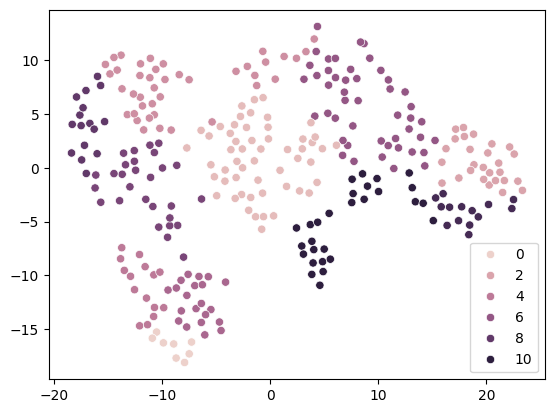

In [ ]:
# graficar con el algoritmo t-SNE para visualizar los grupos
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
# grupos predichos
X_t = tsne.fit_transform(X) # entrenar y transformar los datos originales X
sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], hue = pred) # mostrar los datos resultantes en una gráfica

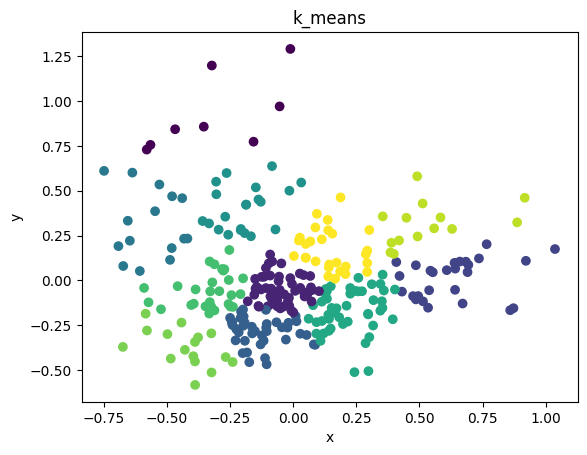

In [ ]:
# Visualización en 2D usando PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, cmap='viridis')
plt.title('k_means')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# Obtener el tamaño de cada cluster
unique_labels, counts = np.unique(pred, return_counts=True)
# Imprime el tamaño de cada cluster
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} equipos")

Cluster 0: 8 equipos
Cluster 1: 54 equipos
Cluster 2: 27 equipos
Cluster 3: 41 equipos
Cluster 4: 15 equipos
Cluster 5: 21 equipos
Cluster 6: 47 equipos
Cluster 7: 28 equipos
Cluster 8: 16 equipos
Cluster 9: 14 equipos
Cluster 10: 28 equipos


### **Gaussian Mixture Model (GMM)**

In [ ]:
#paquetes
from sklearn.mixture import GaussianMixture
# Inicializamos y ajustamos el modelo GMM
gmm = GaussianMixture(n_components=11, random_state=42)
y_pred = gmm.fit_predict(X)
y_pred

array([ 4,  4,  4,  4,  8,  8,  5,  1,  3,  3,  4,  3,  2,  3,  0,  6,  0,
        3,  0,  2,  4,  4,  1,  7,  2,  0,  2,  4,  0,  1,  5,  0,  0,  4,
        2,  1,  1,  0,  4,  3,  1,  5,  9,  0,  4,  4,  9,  4,  4, 10,  8,
       10,  3,  2,  4,  3,  8,  8,  9,  4,  4,  1,  5,  5,  8,  1,  0,  4,
        3,  3,  4,  5,  9,  0,  4,  6,  6, 10,  5,  8,  1,  3,  8,  4,  1,
        8,  3,  4,  5, 10,  7,  1,  4,  1,  5,  4,  2,  1,  9,  5,  1,  5,
        0,  8,  2,  7,  9,  5,  4,  8,  3,  4,  4,  8,  3,  9,  1,  1,  0,
        0,  1,  1,  1,  3,  1,  5,  4,  4,  8,  8,  2,  4,  3, 10,  2,  8,
        2,  4,  5,  3,  1,  1,  1,  8,  4,  3,  3,  1,  8,  0,  9,  7,  4,
        7,  7,  3,  1,  9,  2,  5,  5,  2, 10,  0,  2,  3,  4,  1,  4,  1,
        1,  2,  0,  5,  1,  4,  9,  3,  0,  2,  7,  5,  3,  1,  6,  1, 10,
        4,  4,  5,  1,  4,  7,  4,  0,  8,  8,  9,  5,  1,  4,  0,  0,  1,
        1,  5, 10,  4, 10,  5,  5,  4,  6,  1,  1,  4,  4,  8,  3,  5,  2,
        1,  1,  9,  3,  0

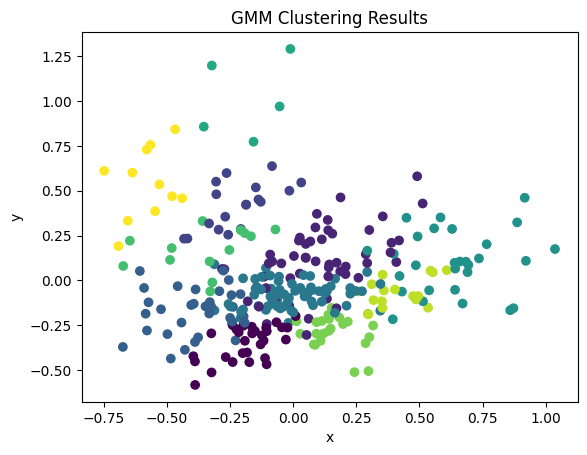

In [ ]:
# Visualización en 2D usando PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis')
plt.title('GMM Clustering Results')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


<Axes: >

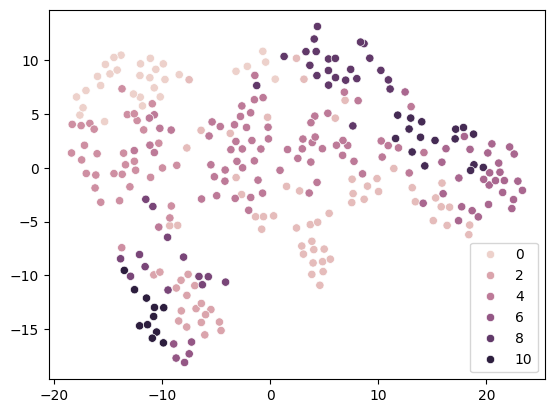

In [ ]:
# graficar con el algoritmo t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
# grupos predichos
X_t = tsne.fit_transform(X) # entrenar y transformar los datos originales X
sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], hue = y_pred) # mostrar los datos resultantes en una gráfica

In [ ]:
# Obtener el tamaño de cada cluster
unique_labels, counts = np.unique(y_pred, return_counts=True)

# Imprime el tamaño de cada cluster
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} equipos")

Cluster 0: 30 equipos
Cluster 1: 52 equipos
Cluster 2: 18 equipos
Cluster 3: 33 equipos
Cluster 4: 69 equipos
Cluster 5: 29 equipos
Cluster 6: 5 equipos
Cluster 7: 13 equipos
Cluster 8: 23 equipos
Cluster 9: 16 equipos
Cluster 10: 11 equipos


###  Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
# Inicializamos y ajustamos el modelo de Agglomerative Clustering con 11 clusters
agg_cluster = AgglomerativeClustering(n_clusters=11)
y_labels = agg_cluster.fit_predict(X)
y_labels

array([ 4,  4,  4,  5,  4,  9,  2,  8,  3,  3,  1,  3, 10,  3,  1,  0,  1,
        3,  1,  7,  4,  1,  5,  7, 10,  1,  7,  4,  1,  4,  2,  1,  1,  4,
        7, 10,  8,  1,  4,  1,  5,  2,  2,  1,  5,  5,  2,  1,  5,  0,  9,
        6,  1,  0,  5,  1,  9,  9,  2,  4,  4, 10,  2,  2,  9,  4,  1,  1,
        1,  3,  3,  2,  2,  1,  5,  0,  0,  0,  2,  9, 10,  1,  9,  5, 10,
        9,  1,  5,  2,  0,  7,  5,  5,  4,  2,  5,  7, 10,  2,  2, 10,  8,
        1,  9,  7,  3,  4,  2,  5,  5,  3,  5,  4,  9,  3,  2,  9, 10,  1,
        1,  4,  1,  8,  3,  8,  8,  4,  5,  9,  9,  7,  5,  3,  6,  7,  9,
        7,  4,  2,  3,  5, 10,  4,  9,  4,  1,  6,  3,  9,  9,  4,  6,  3,
        6,  7,  1,  5,  4,  7,  9,  2,  7,  6,  1,  6,  3,  5,  5,  5,  8,
        4,  7,  1,  8,  4,  4,  4,  3,  1,  6,  6,  8,  3, 10,  0,  5,  6,
        5,  5,  2,  5,  5,  3,  1,  1,  9,  9,  4,  8,  5,  5,  1,  1,  5,
        5,  4,  6,  5,  0,  2,  2,  4,  0,  5,  4,  4,  4,  9,  1,  8,  7,
        4,  5,  4,  3,  1

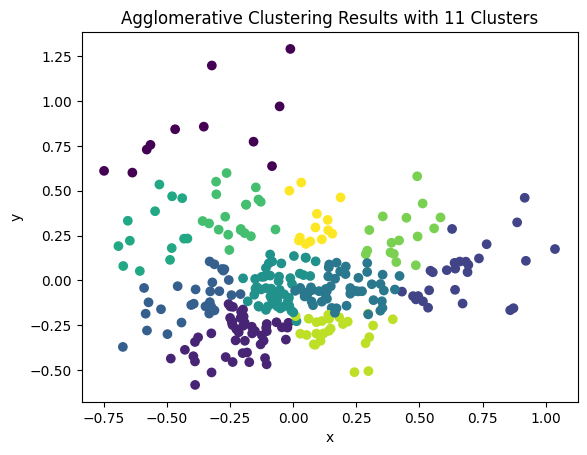

In [ ]:
# 2. Visualización en 2D usando PCA (puedes ajustar esto según la dimensionalidad de tus datos)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 3. Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=y_labels, cmap='viridis')
plt.title('Agglomerative Clustering Results with 11 Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<Axes: >

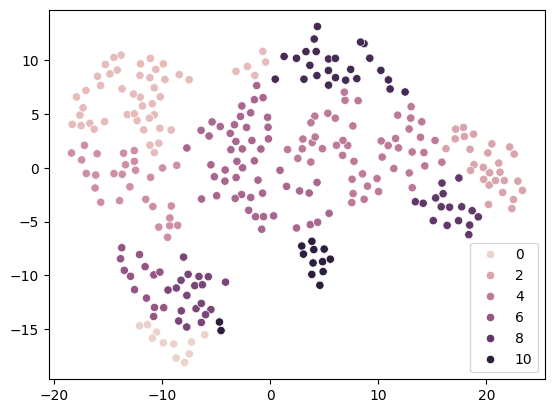

In [ ]:
# graficar con el algoritmo t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
# grupos predichos
X_t = tsne.fit_transform(X) # entrenar y transformar los datos originales X
sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], hue = y_labels) # mostrar los datos resultantes en una gráfica

In [ ]:
# Obtener el tamaño de cada cluster
unique_labels, counts = np.unique(y_labels, return_counts=True)

# Imprime el tamaño de cada cluster
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} equipos")

Cluster 0: 11 equipos
Cluster 1: 48 equipos
Cluster 2: 27 equipos
Cluster 3: 28 equipos
Cluster 4: 48 equipos
Cluster 5: 51 equipos
Cluster 6: 13 equipos
Cluster 7: 19 equipos
Cluster 8: 16 equipos
Cluster 9: 25 equipos
Cluster 10: 13 equipos


### Spectral clustering

In [ ]:
from sklearn.cluster import SpectralClustering
from mpl_toolkits.mplot3d import Axes3D
# Inicializamos y ajustamos el modelo SpectralClustering con 11 clusters
spectral_clustering = SpectralClustering(n_clusters=11, random_state=42)
labels_spectral = spectral_clustering.fit_predict(X)
labels_spectral

array([10,  1,  1, 10,  1,  5,  8,  6,  3,  3, 10,  3,  9, 10, 10,  2,  7,
        3,  7,  9,  1, 10, 10,  9,  9, 10,  9,  1, 10,  1,  8,  7, 10,  1,
        9,  9,  1,  7,  5, 10,  1,  1,  0, 10, 10, 10,  0, 10, 10,  2,  5,
        2,  7,  9, 10, 10,  5, 10,  0,  1,  1,  9,  8,  0,  5,  1,  7, 10,
       10, 10, 10,  0,  0, 10, 10,  4,  9,  2,  0,  5,  9,  7,  5, 10,  9,
        5,  7, 10,  0,  2,  9, 10, 10,  1,  0, 10,  9,  9,  0,  0,  9,  1,
        7,  5,  9, 10,  1,  0, 10, 10,  3, 10,  1,  5,  3,  0, 10,  9,  7,
       10,  1, 10,  1, 10,  1,  6,  1, 10,  5,  5,  9, 10, 10,  2,  9,  5,
        9,  1,  0, 10,  1,  9,  1,  5, 10, 10,  3, 10,  5,  5,  1,  3, 10,
        3,  9,  7, 10,  1,  9,  5,  8,  9,  2,  7,  9, 10, 10,  1, 10,  1,
        1,  9,  7,  1,  1,  1,  1, 10,  7,  9,  3,  6,  3,  9,  4,  1,  2,
       10, 10,  0, 10, 10, 10, 10, 10,  5,  5,  5,  6, 10, 10, 10,  5, 10,
        1,  1,  2, 10,  2,  6,  0,  1,  4,  1,  1,  1,  1,  5,  7,  6,  9,
        1,  1,  1, 10, 10

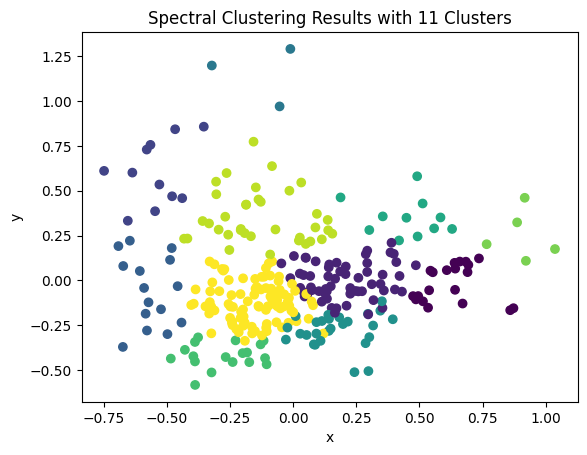

In [ ]:
# 2. Visualización en 2D usando PCA (puedes ajustar esto según la dimensionalidad de tus datos)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 3. Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=labels_spectral, cmap='viridis')
plt.title('Spectral Clustering Results with 11 Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

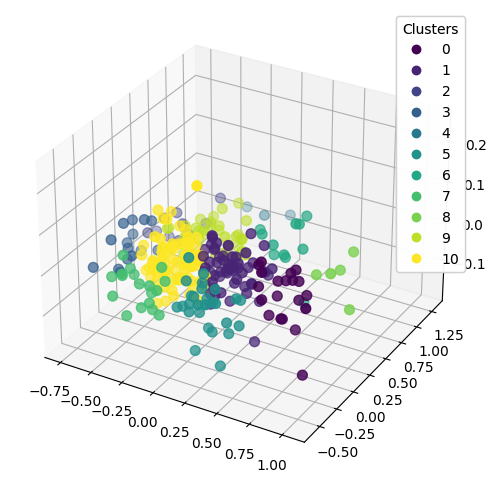

In [ ]:
#3D
# Visualización en 3D usando PCA para reducir la dimensionalidad
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

# Crear una figura en 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot en 3D
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_spectral, cmap='viridis', s=50)
# Añadir leyenda
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

# Mostrar el gráfico
plt.show()

<Axes: >

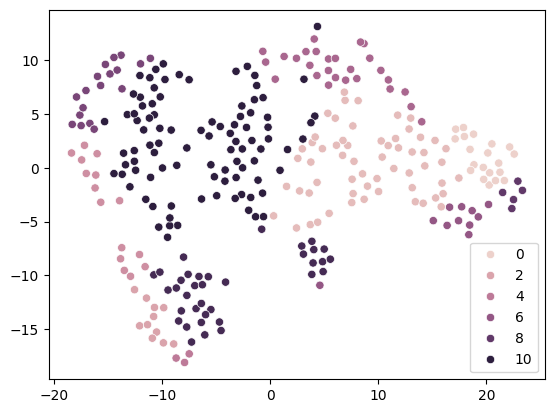

In [ ]:
# graficar con el algoritmo t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
# grupos predichos
X_t = tsne.fit_transform(X) # entrenar y transformar los datos originales X
sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], hue = labels_spectral) # mostrar los datos resultantes en una gráfica

In [ ]:
# Obtener el tamaño de cada cluster
unique_labels, counts = np.unique(labels_spectral, return_counts=True)

# Imprime el tamaño de cada cluster
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} instancias")

Cluster 0: 20 instancias
Cluster 1: 59 instancias
Cluster 2: 11 instancias
Cluster 3: 15 instancias
Cluster 4: 3 instancias
Cluster 5: 27 instancias
Cluster 6: 11 instancias
Cluster 7: 18 instancias
Cluster 8: 5 instancias
Cluster 9: 36 instancias
Cluster 10: 94 instancias


### Sol del problema

## Probar k-medoids

In [ ]:
pip install scikit-learn-extra


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.6 MB/s eta 0:00:00


In [ ]:
from sklearn_extra.cluster import KMedoids
# Número de grupos deseados
n = 9
# Inicialización del modelo KMedoids
kmedoids = KMedoids(n_clusters=n, random_state=42)
# Entrenar el modelo
kmedoids.fit(X)
# Obtener las etiquetas de los grupos
labels = kmedoids.labels_
# Obtener los medoides (puntos representativos) de cada grupo
medoids = X[kmedoids.medoid_indices_]

In [ ]:
# Obtener el tamaño de cada cluster
unique_labels, counts = np.unique(labels, return_counts=True)

# Imprime el tamaño de cada cluster
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} equipos")

Cluster 0: 35 equipos
Cluster 1: 24 equipos
Cluster 2: 24 equipos
Cluster 3: 40 equipos
Cluster 4: 42 equipos
Cluster 5: 35 equipos
Cluster 6: 31 equipos
Cluster 7: 34 equipos
Cluster 8: 34 equipos


In [ ]:
#puntos representativos de mi conjunto de datos (medoides)
medoids

array([[2.9375    , 1.05263158, 0.55921053, 0.20065789, 0.24013158],
       [2.96825397, 1.61111111, 0.28571429, 0.46825397, 0.24603175],
       [2.72983871, 1.39112903, 0.37903226, 0.35887097, 0.26209677],
       [2.55789474, 1.4       , 0.29473684, 0.42631579, 0.27894737],
       [2.33333333, 1.35555556, 0.27777778, 0.45555556, 0.26666667],
       [2.56578947, 1.61842105, 0.22368421, 0.53947368, 0.23684211],
       [3.05882353, 1.94117647, 0.22058824, 0.54411765, 0.23529412],
       [2.71764706, 1.58235294, 0.28823529, 0.45882353, 0.25294118],
       [2.44736842, 1.15413534, 0.41353383, 0.33458647, 0.2518797 ]])

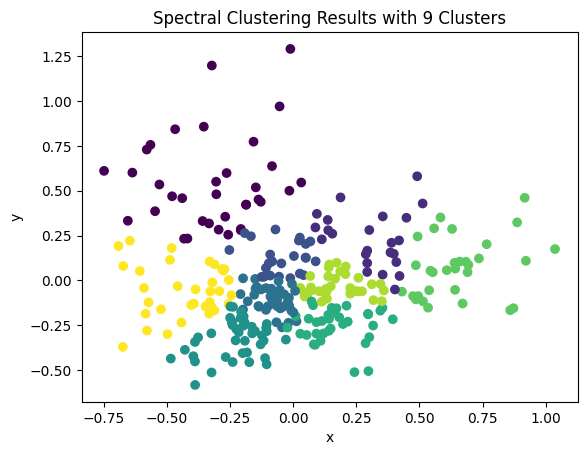

In [ ]:
# 2. Visualización en 2D usando PCA (puedes ajustar esto según la dimensionalidad de tus datos)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 3. Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=labels, cmap='viridis')
plt.title('Spectral Clustering Results with 9 Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<Axes: >

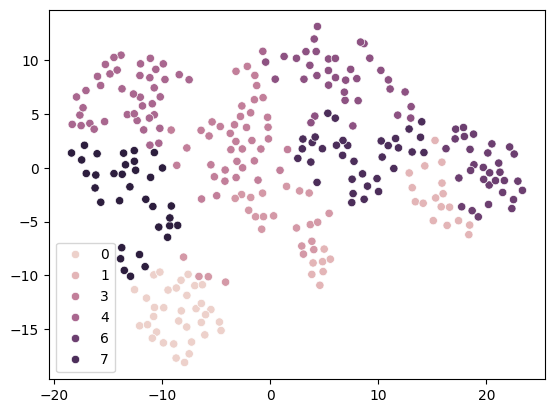

In [ ]:
# graficar con el algoritmo t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
# grupos predichos
X_t = tsne.fit_transform(X) # entrenar y transformar los datos originales X
sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], hue = labels) # mostrar los datos resultantes en una gráfica

#Analizar los medoides

In [ ]:
# Obtener los índices de los medoides
medoid_index = kmedoids.medoid_indices_
medoid_index

array([ 19, 173,  40, 235, 194, 196, 247,   2, 165])

<Axes: >

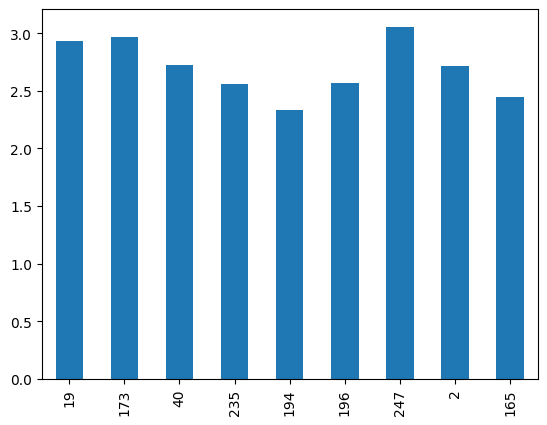

In [ ]:
#pormedio de goles
df_teams_new["avg_goals"].iloc[medoid_index].plot(kind="bar")

<Axes: >

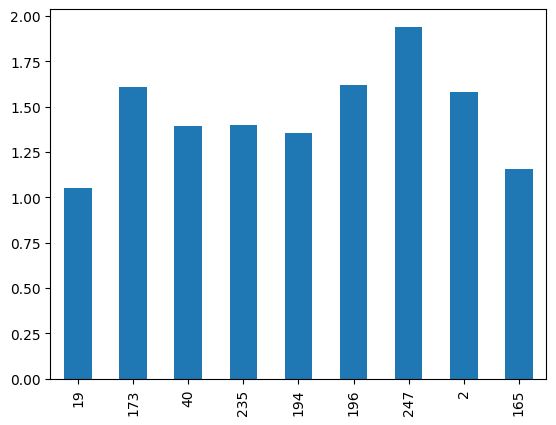

In [ ]:
#promedio de goles en contra
df_teams_new["avg_goals_conceded"].iloc[medoid_index].plot(kind="bar")

<Axes: >

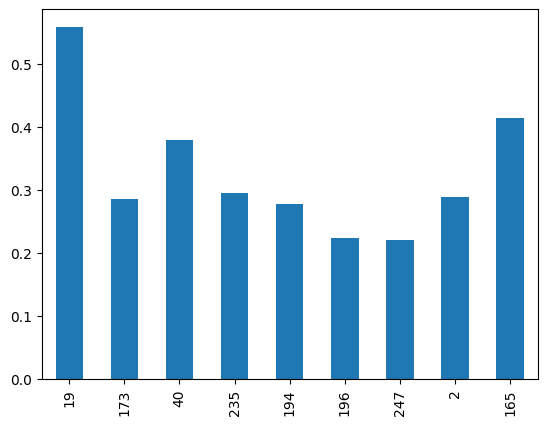

In [ ]:
#porcentaje de victorias
df_teams_new["win_percentage"].iloc[medoid_index].plot(kind="bar")

<Axes: >

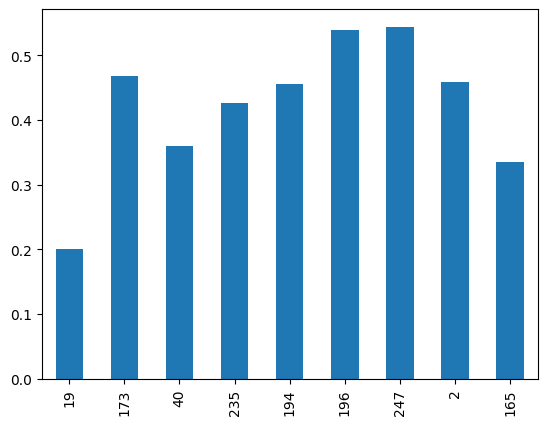

In [ ]:
#porcentaje de derrotas
df_teams_new["loss_percentage"].iloc[medoid_index].plot(kind="bar")

<Axes: >

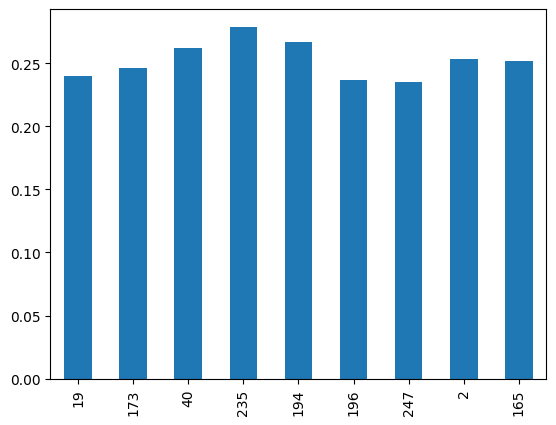

In [ ]:
#porcentaje de empate
df_teams_new["draw_percentage"].iloc[medoid_index].plot(kind="bar")

#Puntaje de Calinski

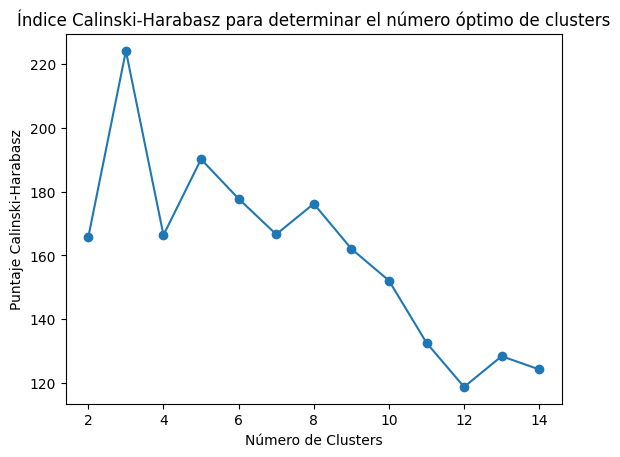

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt

# Rango de los clusters
num_clusters_range = range(2, 15)

# Lista para almacenar los puntajes Calinski-Harabasz
calinski_scores = []

for k in num_clusters_range:
    kmedoids = KMedoids(n_clusters=k,random_state=42)
    kmedoids.fit(X)
    score = calinski_harabasz_score(X, kmedoids.labels_)
    calinski_scores.append(score)
# Graficar los resultados
plt.plot(num_clusters_range, calinski_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntaje Calinski-Harabasz')
plt.title('Índice Calinski-Harabasz para determinar el número óptimo de clusters')
plt.show()

### Proponer modificacion

In [ ]:
# Paso 2
# Asignación
# Función para asignar centroides
def AssignCentroideMaxCluster(X_centroids, y_centroids, X, max_cluster_size, p=2):
    Mxnew = len(X)
    ynew = np.zeros(Mxnew, dtype=int)
    cluster_sizes = np.zeros(len(y_centroids), dtype=int)

    for i in range(Mxnew):
        dist = ML.getDistances(X[i], X_centroids, y_centroids, p)
        dist.sort(key=lambda pair: pair[0])

        # Buscar el índice del centroide más cercano que no haya alcanzado su límite
        for _, idx in dist:
            #centroid_label = int(y_centroids[int(idx)])  # Convertir el índice a entero
            centroid_label=int(idx)
            if cluster_sizes[centroid_label] < max_cluster_size:
                ynew[i] = centroid_label
                cluster_sizes[centroid_label] += 1
                break

    return ynew
# Paso 4
# Repetición
# Repetir los pasos anteriores
def k_means_MaxCluster(X, k, MAXITE, max_cluster_size, p=2):
    X_centroids, y_centroids = ML.randomCentroids(X, k)

    for i in range(MAXITE):
        y_pred = AssignCentroideMaxCluster(X_centroids, y_centroids, X, max_cluster_size, p)
        X_centroids, y_centroids = ML.getCentroids(X, y_pred)

    return y_pred


In [ ]:
# Ejemplo de uso:
y_pred = k_means_MaxCluster(X, k=11, MAXITE=100, max_cluster_size=28, p=2)


In [ ]:
y_pred

array([ 1,  1,  1, 10,  1,  5,  7,  6,  4,  4,  2,  4,  3,  4,  2,  3,  4,
        4,  2,  3,  1,  2, 10,  9,  3,  2,  3,  1,  2,  0,  7,  4,  2,  0,
        3, 10,  6,  2,  0,  2, 10,  0,  7,  2, 10,  8,  0,  5,  8,  3,  5,
        3,  4,  3,  8,  2,  5,  5,  0,  0,  1, 10,  7,  0,  0,  6,  2,  8,
        2,  8,  9,  7,  7,  2,  8,  3,  3,  3,  7,  5,  6,  4,  0,  8, 10,
        5,  4,  8,  7,  3, 10, 10,  8,  6,  7,  8,  3,  6,  0,  7,  6,  6,
        2,  5,  3,  9,  0,  7,  8,  5,  4, 10,  1,  5,  9,  7,  5, 10,  4,
        2,  1,  2,  6,  4,  6,  6,  1,  8,  5,  5,  9, 10,  8,  9,  3,  5,
       10,  1,  0,  8, 10,  6,  1,  5,  1,  8,  9,  9,  5,  5,  0,  9,  4,
        9,  9,  2,  8,  0,  9,  0,  7,  3,  3,  2,  9,  9,  8, 10,  8,  6,
        6,  9,  2,  6,  1,  0,  0,  4,  2,  9,  9,  7,  4,  6,  3,  1,  9,
        8,  8,  7,  8,  8,  9,  8,  2,  5,  5,  0,  6,  8,  8,  2,  2,  8,
        1,  0,  3,  8,  3,  7,  7,  1,  3, 10,  1,  1,  1,  5,  4,  7,  3,
        1, 10,  0,  4,  2

In [ ]:
np.bincount(y_pred)

array([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 19])

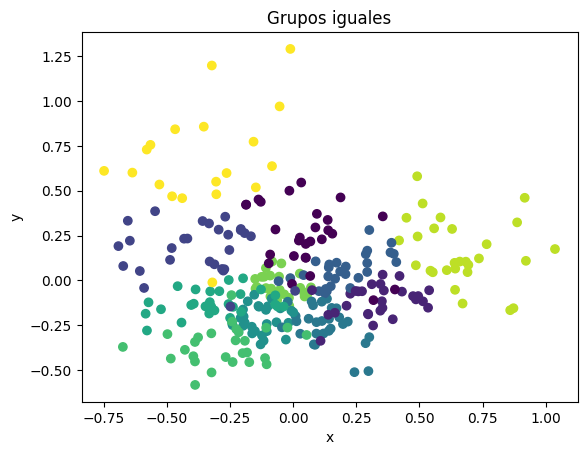

In [ ]:
# 2. Visualización en 2D usando PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 3. Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=y_pred, cmap='viridis')
plt.title('Grupos iguales')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

normal

In [ ]:
y_pred1=ML.k_means(X,11,100)

In [ ]:
y_pred1

array([10,  0,  0,  0, 10,  9,  7,  2,  6,  5,  4,  5,  1,  5,  4,  3,  6,
        6,  6,  1,  0,  4,  0,  1,  2,  4,  1,  0,  4,  8,  7,  6,  4,  8,
        1,  0,  8,  4,  8,  4,  0,  8,  7,  4,  0,  0,  8,  4,  4,  3,  9,
        1,  6,  1,  4,  4,  9,  9,  8, 10,  0,  0,  7,  8, 10,  8,  4,  4,
        4,  5,  5,  7,  7,  4,  0,  3,  3,  3,  7, 10,  2,  6, 10,  0,  0,
        9,  6,  0,  7,  3,  1,  0,  4,  0,  7,  0,  1,  2,  8,  7,  2,  2,
        4,  9,  1,  5,  8,  7,  0,  4,  6,  0,  0,  9,  5,  7, 10,  0,  6,
        4,  0,  4,  2,  5,  2,  2,  0,  0, 10, 10,  1,  0,  4,  1,  1, 10,
        1,  0,  8,  5,  0,  2,  8, 10,  0,  4,  5,  5, 10, 10,  8,  5,  4,
        5,  1,  4,  0,  8,  1,  8,  7,  1,  1,  4,  1,  5,  4,  0,  0,  2,
        8,  1,  6,  2,  0,  8,  8,  4,  4,  1,  5,  7,  5,  2,  3,  0,  1,
        0,  0,  7,  4,  0,  5,  4,  4, 10, 10,  8,  2,  0,  4,  4,  4,  4,
        0,  8,  1,  4,  3,  7,  7,  0,  3,  0, 10,  0, 10,  9,  6,  7,  1,
        0,  0,  8,  5,  4

In [ ]:
np.bincount(y_pred1)

array([60, 28, 20, 10, 55, 26, 15, 22, 31, 11, 21])

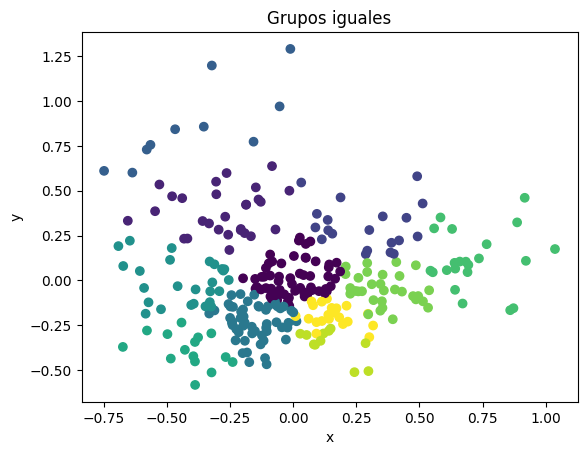

In [ ]:
# 2. Visualización en 2D usando PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 3. Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=y_pred1, cmap='viridis')
plt.title('Grupos iguales')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

modificacion 2

In [ ]:
def AssignCentroideMaxCluster1(X_centroids, y_centroids, X, max_cluster_size, p=2):
    Mxnew = len(X)
    ynew = np.zeros(Mxnew, dtype=int)
    cluster_sizes = np.zeros(len(y_centroids), dtype=int)

    # Inicializar lista de puntos sobrantes para cada centroide
    points_overflow = [[] for _ in range(len(y_centroids))]

    # Asignar cada punto al centroide más cercano
    for i in range(Mxnew):
        dist_to_centroids = [ML.disMinkowski(X[i], c, p) for c in X_centroids]
        centroid_label = np.argmin(dist_to_centroids)
        ynew[i] = y_centroids[centroid_label]
        cluster_sizes[centroid_label] += 1

        # Si el tamaño del cluster excede el límite, agregar punto a lista de sobrantes
        if cluster_sizes[centroid_label] > max_cluster_size:
            points_overflow[centroid_label].append(i)

    # Reasignar puntos sobrantes a otros centroides mientras se cumple el límite de tamaño
    for centroid_label, overflow in enumerate(points_overflow):
        while overflow:
            # Ordenar los puntos sobrantes por distancia al centroide actual
            overflow.sort(key=lambda x: ML.disMinkowski(X[x], X_centroids[centroid_label], p))

            # Reasignar punto sobrante al centroide más cercano disponible
            for i in overflow:
                dist_to_centroids = [ML.disMinkowski(X[i], c, p) for c in X_centroids]
                sorted_centroids = np.argsort(dist_to_centroids)

                for idx in sorted_centroids:
                    if cluster_sizes[idx] < max_cluster_size:
                        ynew[i] = y_centroids[idx]
                        cluster_sizes[idx] += 1
                        overflow.remove(i)
                        break

    return ynew

def k_means_MaxCluster1(X, k, MAXITE, max_cluster_size, p=2):
    X_centroids, y_centroids = ML.randomCentroids(X, k)

    for i in range(MAXITE):
        y_pred = AssignCentroideMaxCluster1(X_centroids, y_centroids, X, max_cluster_size, p)
        X_centroids, y_centroids = ML.getCentroids(X, y_pred)

    return y_pred


In [ ]:
y_pred2= k_means_MaxCluster1(X, 11, 100, 28)

In [ ]:
y_pred2

array([10, 10,  0,  8,  2,  2,  6,  6,  4,  4,  3,  4,  9,  4,  3,  5,  4,
        4,  3,  5, 10,  3,  9,  7,  9,  3,  5,  0,  3,  0,  6,  3,  3,  0,
        5,  9,  1,  3,  1,  3,  9,  1,  6,  3,  8, 10,  1, 10,  8,  5,  2,
        5,  4,  5, 10,  3,  2,  2,  1,  0,  0,  9,  6,  1,  2,  0,  3,  8,
        3,  8,  7,  6,  6,  3, 10,  5,  5,  5,  6,  2,  9,  4,  1,  8,  9,
        2,  4,  8,  1,  5,  7,  8, 10,  0,  6,  8,  5,  9,  1,  6,  9,  1,
        3,  2,  5,  7,  1,  6,  8, 10,  4,  8, 10,  2,  4,  6,  2,  9,  3,
        3,  0,  3,  6,  4,  1,  6, 10, 10,  2,  2,  7,  8,  8,  7,  5,  2,
        7, 10,  1,  8,  9,  9,  0,  2, 10,  8,  7,  7,  2, 10,  0,  7,  4,
        7,  7,  3, 10,  1,  7,  1,  6,  5,  5,  3,  7,  4, 10,  9,  8,  0,
        0,  7,  3,  0,  0,  0,  1,  4,  3,  7,  7,  6,  4,  9,  5,  9,  7,
        8,  8,  6,  8, 10,  8,  8,  3,  2,  2,  1,  6,  8, 10,  3,  3, 10,
        9,  1,  5, 10,  5,  6,  6,  0,  5,  9,  0,  0, 10,  2,  4,  6,  5,
        0, 10,  1,  4,  3

In [ ]:
np.bincount(y_pred2)

array([28, 26, 28, 28, 28, 22, 28, 27, 28, 28, 28])

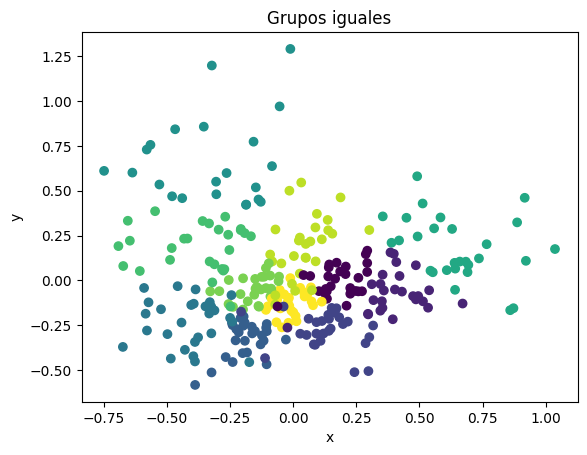

In [ ]:
# 2. Visualización en 2D usando PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# 3. Visualización de los resultados
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=y_pred2, cmap='viridis')
plt.title('Grupos iguales')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
ML.getCentroids(X,y_pred2)

(array([[2.76302295, 1.59480634, 0.28415917, 0.45526753, 0.26057331],
        [2.80782027, 1.78856141, 0.21225586, 0.54391594, 0.2438282 ],
        [2.50918156, 1.62571492, 0.19763062, 0.54494465, 0.25742473],
        [2.32097274, 1.3865994 , 0.25248586, 0.47037618, 0.27713796],
        [2.29064253, 1.18501532, 0.34163485, 0.37772451, 0.28064064],
        [3.08602501, 0.97168804, 0.6278678 , 0.17152331, 0.20060889],
        [3.13162815, 1.92673093, 0.24831204, 0.52616079, 0.22552717],
        [2.65303077, 1.08537807, 0.48251362, 0.26498743, 0.25249895],
        [2.56752798, 1.33861809, 0.33795938, 0.38021203, 0.28182859],
        [2.85686778, 1.4250783 , 0.37957767, 0.37500711, 0.24541522],
        [2.56982601, 1.47613668, 0.28035279, 0.45498304, 0.26466417]]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [ ]:
def getCentroidIndices(X_data, y_data):
    y_unique = np.unique(y_data)  # Vector con valores de y_data sin repetir
    centroid_indices = []

    for label in y_unique:
        indices = np.where(y_data == label)[0]  # Obtenemos los índices de los puntos con la etiqueta actual
        centroid_indices.append(indices[0])  # Tomamos el primer índice como representante del centroide

    return centroid_indices

In [ ]:
i=getCentroidIndices(X,y_pred2)

<Axes: >

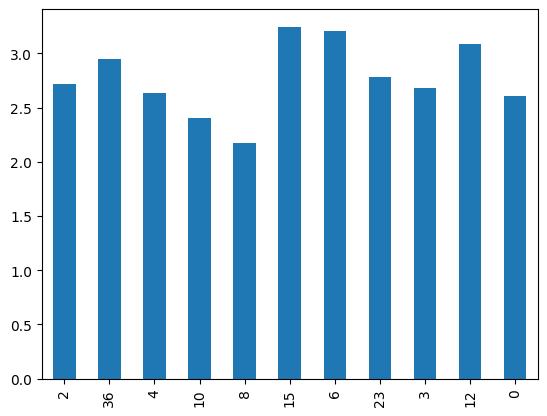

In [ ]:
#pormedio de goles
df_teams_new["avg_goals"].iloc[i].plot(kind="bar")

<Axes: >

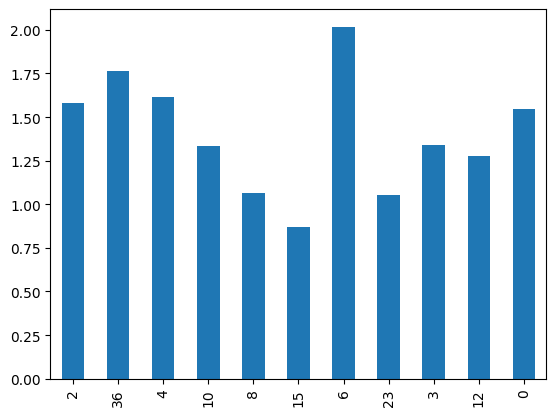

In [ ]:
df_teams_new["avg_goals_conceded"].iloc[i].plot(kind="bar")

<Axes: >

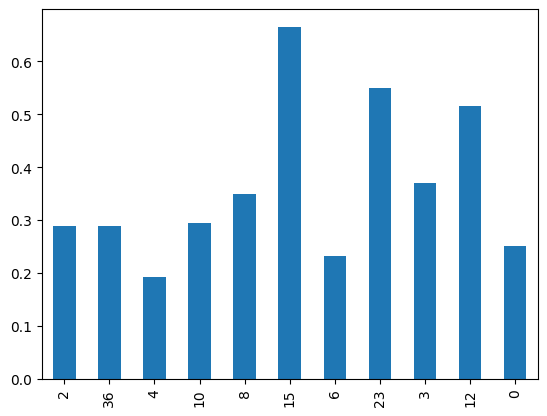

In [ ]:
df_teams_new["win_percentage"].iloc[i].plot(kind="bar")

<Axes: >

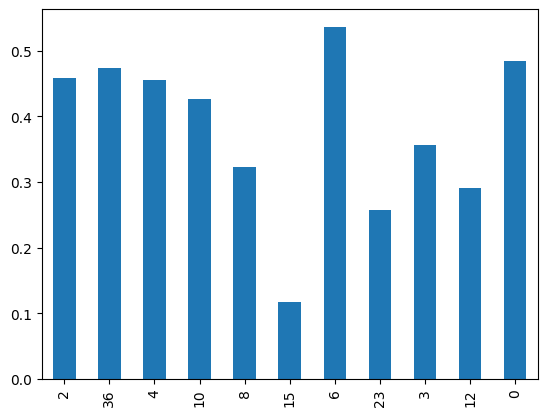

In [ ]:
df_teams_new["loss_percentage"].iloc[i].plot(kind="bar")

<Axes: >

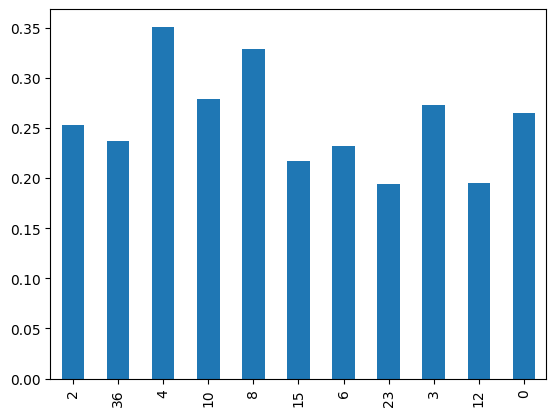

In [ ]:
df_teams_new["draw_percentage"].iloc[i].plot(kind="bar")